We define a method below to create a noise-free DWI signal using a multi-tensor model.

In [16]:
import numpy as np

from dipy.core.gradients import gradient_table
from dipy.core.sphere import disperse_charges, HemiSphere, Sphere
from dipy.sims.voxel import multi_tensor
from sklearn.gaussian_process import GaussianProcessRegressor

def create_multitensor_dmri_signal(hsph_dirs):
    """Create a multi-tensor, noise-free dMRI signal for simulation purposes. It
    simulates two tensors crossing at 90 degrees with equal signal fraction, and
    ``hsph_dirs`` diffusion-encoding gradients at b=1000 s/mm^2, plus a b0
    volume."""

    # Eigenvalues of tensors
    eval1 = [0.0015, 0.0003, 0.0003]
    eval2 = [0.0015, 0.0003, 0.0003]
    mevals = np.array([eval1, eval2])

    # Polar coordinates (theta, phi) of the principal axis of each tensor
    angles = [(0, 0), (90, 0)]

    # Percentage of the contribution of each tensor
    fractions = [50, 50]

    # Create the gradient table placing random points on a hemisphere
    rng = np.random.default_rng(1234)
    theta = np.pi * rng.random(hsph_dirs)
    phi = 2 * np.pi * rng.random(hsph_dirs)
    hsph_initial = HemiSphere(theta=theta, phi=phi)

    # Move the points so that the electrostatic potential energy is minimized
    iterations = 5000
    hsph_updated, potential = disperse_charges(hsph_initial, iterations)
    # Create a sphere
    sph = Sphere(xyz=np.vstack((hsph_updated.vertices, -hsph_updated.vertices)))

    # Create the gradients
    vertices = sph.vertices
    values = np.ones(vertices.shape[0])
    bvecs = vertices
    bval_shell1 = 1000
    bvals = bval_shell1 * values

    # Add a b0 value to the gradient table
    bvecs = np.insert(bvecs, 0, np.array([0, 0, 0]), axis=0)
    bvals = np.insert(bvals, 0, 0)
    gtab = gradient_table(bvals, bvecs)

    # Create a noise-free signal
    snr = None
    S0 = 100
    signal, sticks = multi_tensor(
        gtab, mevals, S0=S0, angles=angles, fractions=fractions, snr=snr
    )

    grad = np.vstack([gtab.bvecs.T, gtab.bvals])

    return signal, sticks, grad, mevals, angles, fractions

We now create the DWI signal using 30 directions defined on the half sphere.

In [17]:
hsph_dirs = 90
signal, sticks, grad, mevals, angles, fractions = create_multitensor_dmri_signal(hsph_dirs)

Since there is only a single voxel in the simulated DWI signal, we add 3 axes before the diffusion-encoding gradient axis so that the plotting method can appropriately represent it. 

In [18]:
voxel_idx = [0, 0, 0]
dwi_data = signal[np.newaxis, np.newaxis, np.newaxis, :]

Plot the data

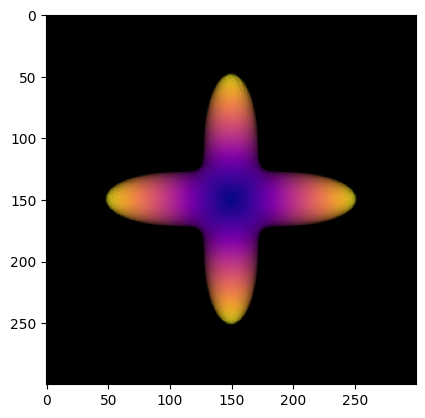

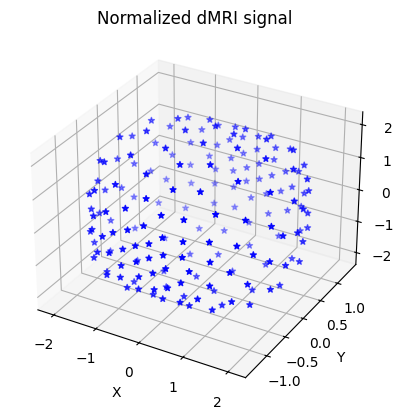

In [19]:
from dipy.sims.voxel import multi_tensor, multi_tensor_odf
from dipy.data import get_sphere

from matplotlib import pyplot as plt 
%matplotlib inline

sphere = get_sphere('symmetric724')
sphere = sphere.subdivide(2)

odf = multi_tensor_odf(sphere.vertices, mevals, angles, fractions)

from dipy.viz import window, actor
scene = window.Scene()

odf_actor = actor.odf_slicer(odf[None, None, None, :], sphere=sphere, colormap='plasma')
odf_actor.RotateX(90)

scene.add(odf_actor)
scene_array = window.snapshot(scene, offscreen=True)
plt.imshow(scene_array)

def plot_dwi(dwi_data, bvecs, b0_mask, voxel_idx, b0_idx):

    s0_voxel = dwi_data[voxel_idx[0], voxel_idx[1], voxel_idx[2], b0_idx]
    s_voxel = dwi_data[voxel_idx[0], voxel_idx[1], voxel_idx[2], ~b0_mask]

    # Scale gradient vector values with DWI signal
    s_normal = s_voxel/s0_voxel
    scaled_vectors = bvecs[:, ~b0_mask] / s_normal[np.newaxis, :]

    # Plot the DWI signal as a 3D point cloud
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    _ = ax.scatter(scaled_vectors[0, :], scaled_vectors[1, :], scaled_vectors[2, :], c="blue", marker="*")

    # Set labels
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Normalized dMRI signal")

    return fig

voxel_idx = [0, 0, 0]
dwi_data = signal[np.newaxis, np.newaxis, np.newaxis, :]
b0_mask = grad[3, :] <= 50
# There is only one b0 volume in the simulated signal
b0_idx = 0
_ = plot_dwi(dwi_data, grad[:3, :], b0_mask, voxel_idx, b0_idx)
plt.show()

We now define the kernel that we will be using for the Gaussian process

In [ ]:
from src.eddymotion.model.dipy import PairwiseOrientationKernel

lambda_s = 2.0
a = 1.0
sigma_sq = 0.5
kernel = PairwiseOrientationKernel(weighting="spherical", lambda_s=lambda_s, a=a, sigma_sq=sigma_sq)

The ``grad`` gradient table instance is in RAS+b format, so we choose the diffusion-encoding gradient vectors (leaving out the first index, which corresponds to the b0 volume) to fit the Gaussian process.

In [ ]:
_grad = grad[:3, 1:]
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)
gpr.fit(_grad.T, signal[1:])

Now predict the signal on the last diffusion-encoding gradient vector.  

In [ ]:
_grad_pred = grad[:3, -1]
y_mean, y_std = gpr.predict(_grad_pred, return_std=True)

Check whether the hyperparameters of the kernel have been optimized

In [ ]:
gpr.kernel_

Plot the training data and the predictions from the Gaussian process

In [ ]:
from matplotlib import pyplot as plt 
%matplotlib inline

s = dwi_data[voxel_idx[0], voxel_idx[1], voxel_idx[2], :]
s_hat_mean = y_mean[voxel_idx[0], voxel_idx[1], voxel_idx[2], :]
s_hat_stddev = y_std[voxel_idx[0], voxel_idx[1], voxel_idx[2], :]
x = np.asarray(range(len(grad.bvals)))

fig, ax = plt.subplots()
ax.plot(x, s_hat_mean, c="orange", label="predicted")
plt.fill_between(
    x.ravel(),
    s_hat_mean - 1.96 * s_hat_stddev,
    s_hat_mean + 1.96 * s_hat_stddev,
    alpha=0.5,
    color="orange",
    label=r"95% confidence interval",
)
plt.scatter(x, s, c="b", label="ground truth")
ax.set_xlabel("bvec indices")
ax.set_ylabel("signal")
ax.legend()
plt.title("Gaussian process regression on dataset")

plt.show()